# Práctica de laboratorio 3 de Inteligencia artificial, grupo 10:
* Alejandro López Gómez
* Emilio Macías Do Santos
* Cristina Del Pilar Mallaupoma Cáceres

En esta práctica hemos optado por utilizar autoencoders para detectar anomalias en las imágenes.

Primero importamos las librerías necesarias:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

Adquisición de los datos y creación del conjunto de entrenamiento con ruido:

In [ ]:
# Cargar los datos CIFAR-10
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data() # No son necesarias las y ya que trabajaremos sobre las imagenes

class2txt = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Normalizar los datos
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

Mostramos las imagenes de entrenamiento:

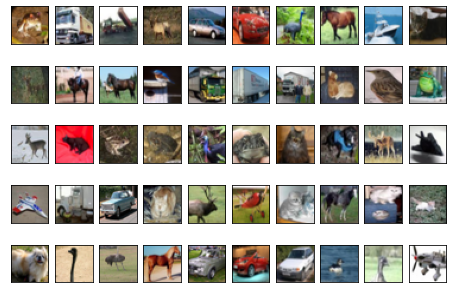

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 10) 
fig.tight_layout(pad=-1)
plt.gray()
a = 0 
for i in range(5): 
  for j in range(10): 
    axs[i, j].imshow(tf.squeeze(x_train[a])) 
    axs[i, j].xaxis.set_visible(False) 
    axs[i, j].yaxis.set_visible(False) 
    a = a + 1

Creamos las anomalias en los datos:

In [ ]:
# Seleccionamos algunos ejemplos aleatorios de la base de datos de entrenamiento
random_indices = np.random.randint(0, len(x_test), size=100) # Cogemos este numero de anomalos para una sencilla explicación y muestra
x_test_anomalia = x_test[random_indices]


# Modificamos las imágenes seleccionadas para crear las anomalías
for i in range(len(x_test_anomalia)):
    x_test_anomalia[i] = np.flip(x_test_anomalia[i], axis=1)
    x_test_anomalia[i] = np.rot90(x_test_anomalia[i], k=np.random.randint(1,4))


Conjunto de datos con anomalias:

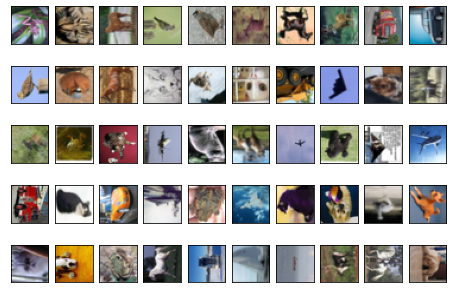

In [ ]:
# Mostrar imagenes anomalas

import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 10) 
fig.tight_layout(pad=-1)
plt.gray()
a = 0 
for i in range(5): 
  for j in range(10): 
    axs[i, j].imshow(tf.squeeze(x_test_anomalia[a])) 
    axs[i, j].xaxis.set_visible(False) 
    axs[i, j].yaxis.set_visible(False) 
    a = a + 1


In [ ]:
# Adaptamos los datos con reshape
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_test_anomalia = x_test_anomalia.reshape((len(x_test_anomalia), np.prod(x_test_anomalia.shape[1:])))

Después de habernos creado las anomalías procederemos a crearnos el modelo de autoencoder y entrenarlo con los datos sin anomalías, ya que los datos con anomalías los utilizaremos posteriormente.

In [ ]:
# Entrenamiento autoencoder

encoding_dim = 32
dim = 3072

# Creación capas
input_img = Input(shape=(dim,))
encoded = Dense(encoding_dim, activation='relu')(input_img) # Capa cuello de botella.
decoded = Dense(dim, activation='sigmoid')(encoded)         # Capa de entrada/salida.

# Creación modelo
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenamos el modelo
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
196/196 [==============================] - 3s 15ms/step - loss: 0.0471 - val_loss: 0.0387
Epoch 2/50
196/196 [==============================] - 3s 15ms/step - loss: 0.0369 - val_loss: 0.0355
Epoch 3/50
196/196 [==============================] - 3s 15ms/step - loss: 0.0349 - val_loss: 0.0339
Epoch 4/50
196/196 [==============================] - 3s 15ms/step - loss: 0.0335 - val_loss: 0.0326
Epoch 5/50
196/196 [==============================] - 3s 15ms/step - loss: 0.0322 - val_loss: 0.0316
Epoch 6/50
196/196 [==============================] - 3s 15ms/step - loss: 0.0311 - val_loss: 0.0306
Epoch 7/50
196/196 [==============================] - 3s 16ms/step - loss: 0.0301 - val_loss: 0.0298
Epoch 8/50
196/196 [==============================] - 3s 15ms/step - loss: 0.0293 - val_loss: 0.0289
Epoch 9/50
196/196 [==============================] - 3s 16ms/step - loss: 0.0285 - val_loss: 0.0282
Epoch 10/50
196/196 [==============================] - 3s 17ms/step - loss: 0.0281 - val_lo

A continuación se muestra cómo se calcula las diferencias entre los datos del conjunto de entrenamiento y las anomalías, buscando semejanzas. Si hay mucha diferencia entre estos datos y sobrepasa el umbral se categorizará como anomalía.

66/66 [==============================] - 0s 2ms/step
100


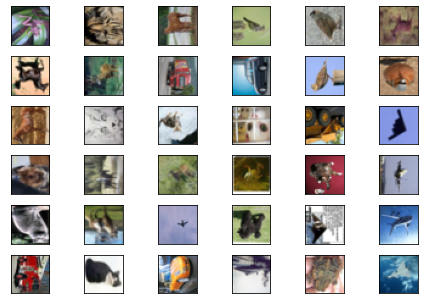

In [ ]:
"""
Tomamos muestras anomalas y muestras correctas, y las juntamos en un mismo array, el autoencoder 
es capaz de discernir entre muestras correctas y muestras anomalas, debido a que ha sido entrenado con 
los datos validos o reales.
"""
# Creamos un conjunto de datos que contenga tanto muestras anomalas como reales

random_indices = np.random.randint(0, len(x_test), size=2000) # Seleccionamos aleatoriamente 2000 muestras de x_test para x_text_mix
x_test_real = x_test[random_indices]

x_test_mix = np.concatenate((x_test_anomalia, x_test_real), axis=0)



# Calcular la pérdida (reconstrucción error) en los datos anómalos y reales, tomando un umbral arbitrario
predicciones_mix = autoencoder.predict(x_test_mix)

umbral_definido = 0.4

# Calcular la distancia promedio entre las representaciones codificadas y las originales
mean_encoded = np.mean(predicciones_mix, axis=0)
dists = np.linalg.norm(x_test_anomalia - mean_encoded, axis=1)
anomalias = []

# Identificar las imágenes anómalas
for i in range(len(dists)):
  if(dists[i] > umbral_definido):
    anomalias.append(i) 

# Mostrar las imágenes anómalas

print(len(anomalias))

ancho = int(len(anomalias)/15)


fig, axs = plt.subplots(ancho, ancho) 
fig.tight_layout(pad=-1)
plt.gray()
a = 0
for i in range(ancho): 
  for j in range(ancho):
    axs[i, j].imshow(x_test_mix[a].reshape(32,32,3)) 
    axs[i, j].xaxis.set_visible(False) 
    axs[i, j].yaxis.set_visible(False) 
    a = a + 1

# Conclusión:
Hemos aprendido a utilizar autoencoders para discriminar anomalías en imágenes, proponiendo ejemplos de anomalías como girar y voltear las imágenes. Después de entrenar el modelo hemos observado cómo es capaz de detectar las imágenes anómalas correctamente.